# Lesson 22: Unsupervised learning demonstration

This notebook demonstrates key concepts and tools for training unsupervised models.

1. Clustering
    - Kmeans
    - Hierarchical
    - DBSCAN
    - Clustering evaluation
    - Determining cluster number

2. Dimensionality reduction
    - PCA
    - Gaussian Random Projection
    - Feature Agglomeration
    - t-SNE

3. Association rule learning
4. Anomaly detection


## Notebook set up

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

### Dataset

In [2]:
# Generate synthetic dataset
data = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=3,
    center_box=(-1.0, 1.0),
    cluster_std=0.1,
    random_state=315
)

# Create dataframe with feature columns
df = pd.DataFrame(data[0], columns=[f'feature_{i}' for i in range(data[0].shape[1])])

# Standard scale the features
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])
df.head()

,feature_0,feature_1
0,0.046546,-1.571411
1,1.001255,1.441644
2,-0.123311,0.312650
3,0.188466,-0.664962
4,-1.378804,-0.635272


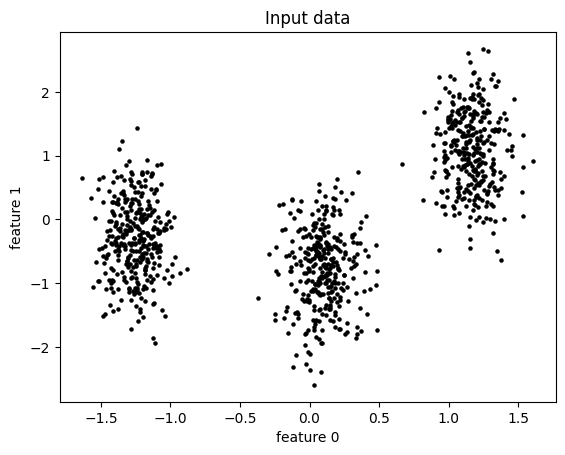

In [3]:
plt.title('Input data')
plt.scatter(df['feature_0'], df['feature_1'], s=5, c='black')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.show()

## 1. Clustering

### 1.1. KMeans

KMeans partitions data into k clusters by minimizing within-cluster variance. Each cluster is represented by its centroid.

Scikit-learn [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) implementation

In [4]:
# Fit KMeans clustering
kmeans = KMeans(n_clusters=3, max_iter=10000, random_state=315)
kmeans_labels = kmeans.fit_predict(df)

# Calculate metrics
kmeans_silhouette = silhouette_score(df, kmeans_labels)

print(f'KMeans - Silhouette: {kmeans_silhouette:.3f}')

KMeans - Silhouette: 0.585


### 1.2. Hierarchical clustering

Hierarchical clustering builds a tree of clusters by either merging (agglomerative) or splitting (divisive) clusters based on distance metrics.

Scikit-learn [Agglomerative Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) implementation

In [5]:
# Fit hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(df)

# Calculate metrics
hierarchical_silhouette = silhouette_score(df, hierarchical_labels)

print(f'Hierarchical - Silhouette: {hierarchical_silhouette:.3f}')

Hierarchical - Silhouette: 0.580


### 1.3. DBSCAN

DBSCAN groups points that are closely packed together, marking points in low-density regions as outliers. It does not require specifying the number of clusters.

Scikit-learn [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) implementation

In [6]:
# Fit DBSCAN clustering
dbscan = DBSCAN(eps=0.179)
dbscan_labels = dbscan.fit_predict(df)

# Count clusters (excluding noise points labeled as -1)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f'DBSCAN found {n_clusters} clusters and {n_noise} noise points')

# Calculate metrics (excluding noise points)
mask = dbscan_labels != -1
dbscan_silhouette = silhouette_score(df[mask], dbscan_labels[mask])

print(f'DBSCAN - Silhouette: {dbscan_silhouette:.3f}')

DBSCAN found 3 clusters and 22 noise points
DBSCAN - Silhouette: 0.595


### 1.4. Clustering evaluation

#### 1.4.1. Silhouette score

In [7]:
# Create comparison dataframe
clustering_results = pd.DataFrame({
    'Method': ['KMeans', 'Hierarchical', 'DBSCAN'],
    'Silhouette': [kmeans_silhouette, hierarchical_silhouette, dbscan_silhouette]
})

clustering_results

,Method,Silhouette
0,KMeans,0.584742
1,Hierarchical,0.579549
2,DBSCAN,0.594669


#### 1.4.2. Scatter plots

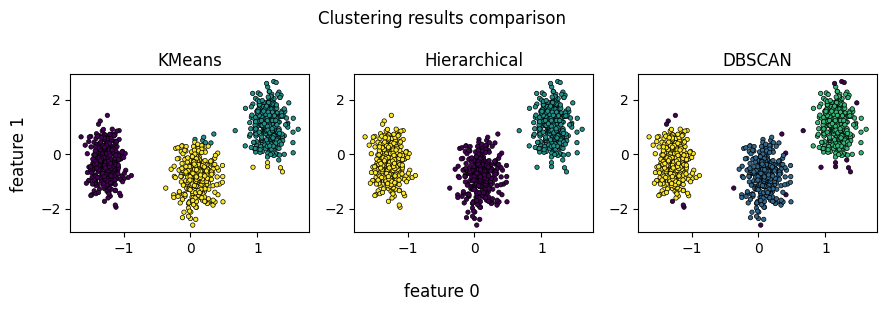

In [8]:
ncols = 3
nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))

fig.suptitle('Clustering results comparison')
fig.supxlabel('feature 0')
fig.supylabel('feature 1')

# KMeans
axes[0].scatter(df['feature_0'], df['feature_1'], c=kmeans_labels, s = 10, edgecolors='black', linewidth=0.5)
axes[0].set_title('KMeans')

# Hierarchical
axes[1].scatter(df['feature_0'], df['feature_1'], c=hierarchical_labels, s = 10, edgecolors='black', linewidth=0.5)
axes[1].set_title('Hierarchical')

# DBSCAN
axes[2].scatter(df['feature_0'], df['feature_1'], c=dbscan_labels, s = 10, edgecolors='black', linewidth=0.5)
axes[2].set_title('DBSCAN')

plt.tight_layout()
plt.show()

#### 1.4.3. Dendrogram (hierarchical clustering only)

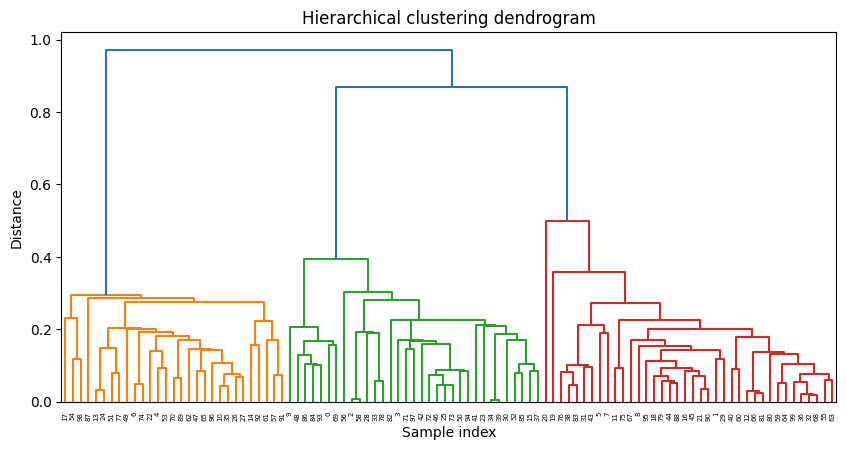

In [9]:
# Create dendrogram
linkage_matrix = linkage(df.iloc[:100])

plt.figure(figsize=(10, 4.8))
dendrogram(linkage_matrix)
plt.title('Hierarchical clustering dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

### 1.5. Determining cluster number: elbow method

The elbow method helps determine the optimal number of clusters by plotting the within-cluster sum of squares (inertia) for different values of k. The optimal k is at the 'elbow' where the rate of decrease sharply changes.

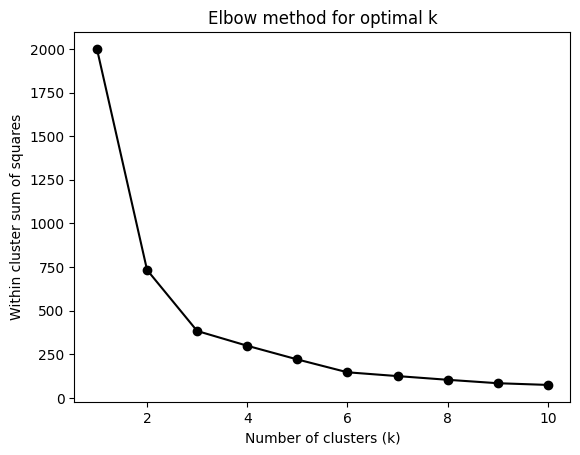

In [10]:
# Calculate inertia for different numbers of clusters
k_range = range(1, 11)
inertias = []

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=315, n_init=10)
    kmeans_temp.fit(df)
    inertias.append(kmeans_temp.inertia_)

# Plot elbow curve
plt.plot(k_range, inertias, marker='o', color='black')
plt.title('Elbow method for optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within cluster sum of squares')
plt.show()

## 2. Dimensionality reduction

### 2.1. High dimensional dataset

In [11]:
# Generate synthetic dataset
data = make_blobs(
    n_samples=1000,
    n_features=50,
    centers=3,
    center_box=(-1.0, 1.0),
    cluster_std=0.1,
    random_state=315
)

# Create dataframe with feature columns
df = pd.DataFrame(data[0], columns=[f'feature_{i}' for i in range(data[0].shape[1])])

# Standard scale the features
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,1.256694,0.925918,1.087221,0.883554,-1.049847,-0.707690,0.417064,0.555339,0.378468,0.365046,...,0.886490,-0.693649,-0.617703,1.431368,1.469504,0.075765,-0.251640,-0.929620,0.688252,-0.740425
1,-1.531803,-1.616026,0.236071,-0.628900,-0.952793,1.456315,0.984622,-1.677839,0.602044,-1.325939,...,0.318230,-0.480626,1.271546,0.375032,-0.150152,1.021512,-1.439857,1.548285,-1.158319,-0.865388
2,1.254366,1.278197,1.058402,1.209665,-0.445653,-0.460368,0.327213,0.342586,0.396004,0.368724,...,0.674427,-1.079359,-0.662391,1.197770,1.313356,0.231063,-0.266190,-1.161755,0.553216,-0.317391
3,0.037400,-0.119921,-1.239298,-1.292340,1.045014,-0.969497,-1.223482,0.496694,-1.293468,0.626882,...,-1.252841,1.109510,-0.821193,-1.287259,-0.498265,-0.971423,1.512486,-0.427935,0.782780,1.237286
4,-0.119609,-0.229481,-0.980120,-1.571966,1.903099,-0.962413,-1.352552,0.842845,-1.422608,0.974448,...,-1.362347,1.446760,-0.557290,-1.308045,-1.530715,-1.461429,1.013111,-0.341431,0.473582,1.248622


### 2.2. PCA

Principal Component Analysis transforms data to a new coordinate system where the greatest variance lies on the first coordinate (first principal component).

Scikit-learn [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) implementation

In [12]:
# Apply PCA
pca = PCA(n_components=5, random_state=315)
pca_components = pca.fit_transform(df)

X_pca = pd.DataFrame(pca_components, columns=pca.get_feature_names_out())
X_pca.head()

,pca0,pca1,pca2,pca3,pca4
0,3.120770,5.612212,1.399804,0.235485,-0.192952
1,4.568902,-4.948957,0.925790,-0.468480,0.114440
2,2.595256,5.390670,-0.372194,0.944008,-0.282021
3,-7.147217,-0.688752,0.327019,-0.638630,0.045469
4,-7.808375,-0.496833,0.039005,0.990713,-0.133383


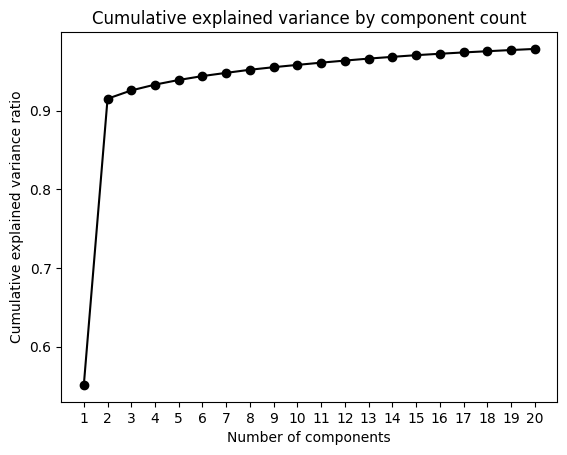

In [13]:
# Evaluate cumulative explained variance across a range of components
comp_range = range(1, 21)
cumulative_variance = []

for n_comp in comp_range:
    pca_temp = PCA(n_components=n_comp, random_state=315)
    pca_temp.fit(df)
    cumulative_variance.append(np.sum(pca_temp.explained_variance_ratio_))

# Plot cumulative explained variance
plt.plot(comp_range, cumulative_variance, marker='o', color='black')
plt.title('Cumulative explained variance by component count')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.xticks(comp_range)
plt.show()

### 2.3. Gaussian Random Projection

Gaussian Random Projection reduces dimensionality by projecting data onto a lower-dimensional space using a random matrix with components drawn from a Gaussian distribution.

Scikit-learn [GaussianRandomProjection](https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.GaussianRandomProjection.html) implementation

In [14]:
# Apply Gaussian Random Projection
grp = GaussianRandomProjection(n_components=2, random_state=315)
X_grp = grp.fit_transform(df)

# Create GRP dataframe
grp_df = pd.DataFrame(X_grp, columns=['GRP1', 'GRP2'])
grp_df.head()

,GRP1,GRP2
0,-5.132300,-7.652607
1,0.080383,2.435841
2,-3.773273,-7.744192
3,4.079753,5.135745
4,7.926188,5.361078


### 2.4. Feature Agglomeration

Feature Agglomeration uses hierarchical clustering to group similar features together, reducing dimensionality while preserving the structure of the data.

Scikit-learn [FeatureAgglomeration](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html) implementation

In [15]:
# Apply Feature Agglomeration
fa = FeatureAgglomeration(n_clusters=2)
X_fa = fa.fit_transform(df)

# Create FA dataframe
fa_df = pd.DataFrame(X_fa, columns=['FA1', 'FA2'])
fa_df.head()

,FA1,FA2
0,-0.242257,0.450116
1,-0.672123,0.670053
2,-0.176537,0.379462
3,0.885729,-1.030763
4,0.896435,-1.123142


### 2.5. t-SNE

t-Distributed Stochastic Neighbor Embedding is a nonlinear dimensionality reduction technique particularly well-suited for visualizing high-dimensional data.

Scikit-learn [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) implementation

In [16]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=315, perplexity=30)#, n_iter=1000)
X_tsne = tsne.fit_transform(df)

# Create t-SNE dataframe
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df.head()

,TSNE1,TSNE2
0,11.034727,28.859167
1,16.348707,-10.077410
2,6.048486,29.936665
3,-23.484877,-2.365246
4,-35.070007,-7.926006


### 2.6. Dimensionality reduction comparison

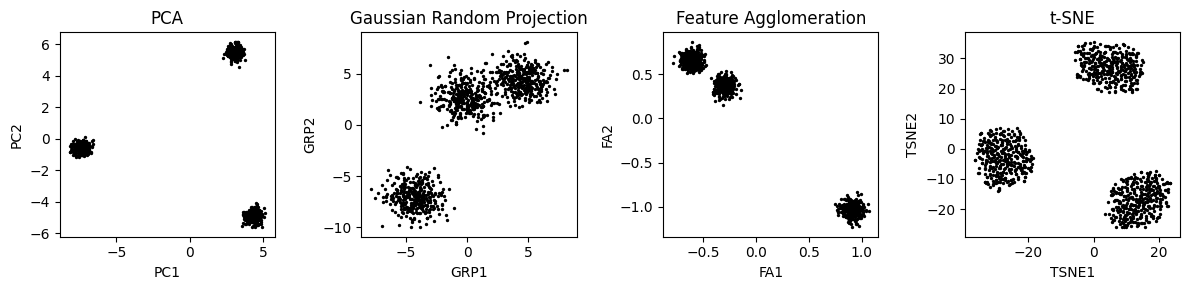

In [17]:
ncols = 4
nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))

# PCA
axes[0].scatter(X_pca.values[:, 0], X_pca.values[:, 1], c='black', s=2)
axes[0].set_title('PCA')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Gaussian Random Projection
axes[1].scatter(X_grp[:, 0], X_grp[:, 1], c='black', s=2)
axes[1].set_title('Gaussian Random Projection')
axes[1].set_xlabel('GRP1')
axes[1].set_ylabel('GRP2')

# Feature Agglomeration
axes[2].scatter(X_fa[:, 0], X_fa[:, 1], c='black', s=2)
axes[2].set_title('Feature Agglomeration')
axes[2].set_xlabel('FA1')
axes[2].set_ylabel('FA2')

# t-SNE
axes[3].scatter(X_tsne[:, 0], X_tsne[:, 1], c='black', s=2)
axes[3].set_title('t-SNE')
axes[3].set_xlabel('TSNE1')
axes[3].set_ylabel('TSNE2')

plt.tight_layout()
plt.show()